# Are the Informational Architectures of Calcium Signals Before and After Dosing Statistically Distinct?

In [1]:
using Pkg
Pkg.activate("..")
using DataFrames, DrWatson, HypothesisTests, LinearAlgebra, Plots, Query, SparseArrays, Statistics, StatsPlots
if haskey(ENV, "GKS_WSTYPE")
    delete!(ENV, "GKS_WSTYPE")
end;
include(srcdir("load.jl"));

Activating environment at `~/dglmoore/yuji/Project.toml`


In [2]:
function results(col, fields::Symbol...)
    tempcol = Symbol(string(col) * "-sparse")
    
    df = collect_results(datadir("info", string(col)); verbose=false)
    disallowmissing!(df)

    select!(df, [:drug, :trial, :gh, :gw, :phase, fields..., col])

    df[!, :gridsize] = (df[:, :gh] .* df[:, :gw]).^2
    df[!, tempcol] = (sparse∘linearize).(df[:, col])
    df[!, :nnz] = nnz.(df[:, tempcol])
    df[!, :eigen] = (real ∘ last ∘ first ∘ eigen ∘ linearize).(df[:, col])
    
    select!(df, Not(col))
    rename!(df, Dict(tempcol => col))
    df
end

results (generic function with 1 method)

In [3]:
macro infoplot(df, xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String, legend::Union{QuoteNode,Bool}=:(:topright))
    quote
        kf = $df |> @filter(_.drug == "K-gluconate")
        knf = $df |> @filter(_.drug == "K-gluconate:Nifedipine")
        
        marker=(:circ, 4, 1.0)
        color=[3 4]
        α=0.5

        kplot = @df kf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df kf violin!(kplot, $xcol, $ycol, group=:phase, α=α, color=color)

        knplot = @df knf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df knf violin!(knplot, $xcol, $ycol, group=:phase, α=α)

        xmin, xmax = extrema($df[:,$xcol])

        plot(kplot, knplot, layout=2, title=["K-gluconate" "K-gluconate + Nifedipine"], titleloc=:left,
             xlabel=$xlabel, xticks=xmin:xmax, ylabel=$ylabel, size=(1000,500), legend=$legend)
    end
end
macro infoplot(xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String, legend::Union{QuoteNode,Bool}=:(:topright))
    :(df -> @infoplot df $xcol $ycol $xlabel $ylabel $legend)
end

@infoplot (macro with 4 methods)

In [4]:
bootstrap(xs::AbstractArray, ys::AbstractArray; f::Function=mean) = f(rand(ys, size(ys)...)) - f(rand(xs, size(xs)...))

function bootstrap(xs::AbstractArray, ys::AbstractArray, N::Int, filt=isfinite; f::Function=mean)
    xnull, ynull = xs .- f(xs), ys .- f(ys)
    stats = [bootstrap(xnull, ynull; f=f) for _ in 1:N]
    stat = bootstrap(xs, ys)
    μ = mean(stats[filt.(stats)])
    a, b = if stat < μ
        stat, 2μ - stat
    else
        2μ - stat, stat
    end
    mean(stats .< a) + mean(stats .> b)
end

bootstrap (generic function with 3 methods)

In [5]:
function significance(df, col::Symbol, fields::Symbol...; N=1000000)
    df = select(df, [:drug, :gh, :gw, :phase, col, fields...])
    by(df, [:drug, :gh, :gw, fields...]) do gf
        before = filter(r -> r[:phase] == "before", gf)
        after = filter(r -> r[:phase] == "after", gf)
        (p = bootstrap(before[:, col], after[:, col], N, s -> s < 1e10), )
    end
end
significance(col::Symbol, fields::Symbol...; N=1000000) = df -> significance(df, col, fields...; N=N)

significance (generic function with 2 methods)

## Mutual Information

In [6]:
@time mi = results(:mi, :lag);

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info/mi for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79


188.948099 seconds (24.67 M allocations: 5.899 GiB, 0.78% gc time)


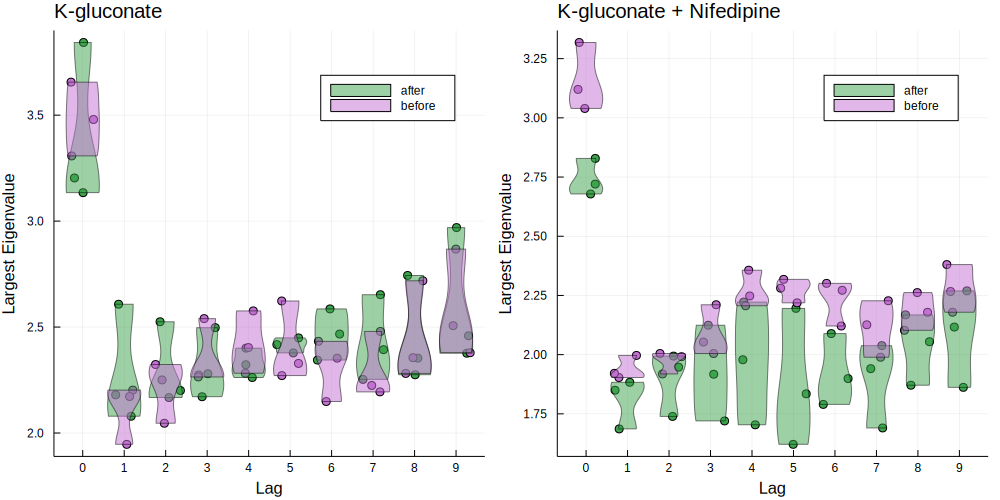

In [7]:
mi |> @filter(_.gh == 30 && _.gw == 30) |> DataFrame |> @infoplot :lag :eigen "Lag" "Largest Eigenvalue"

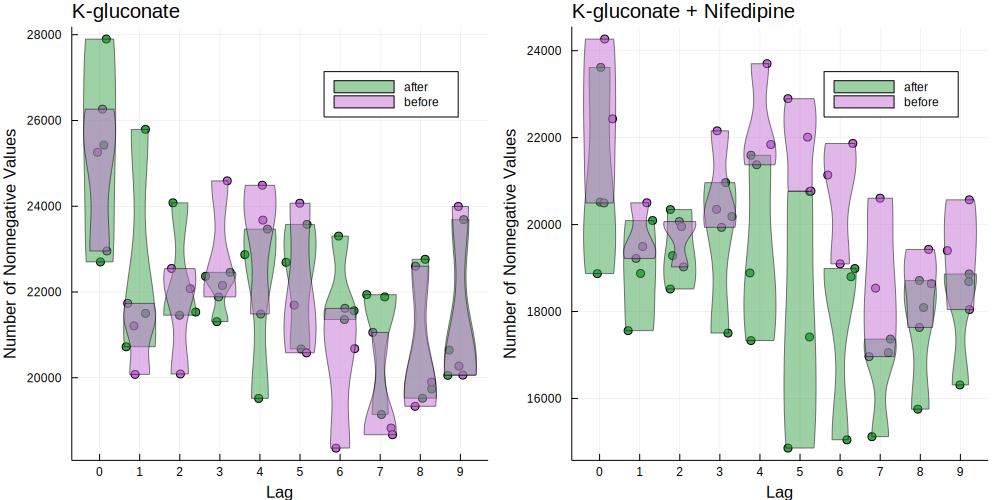

In [8]:
mi |> @filter(_.gh == 30 && _.gw == 30) |> DataFrame |> @infoplot :lag :nnz "Lag" "Number of Nonnegative Values"

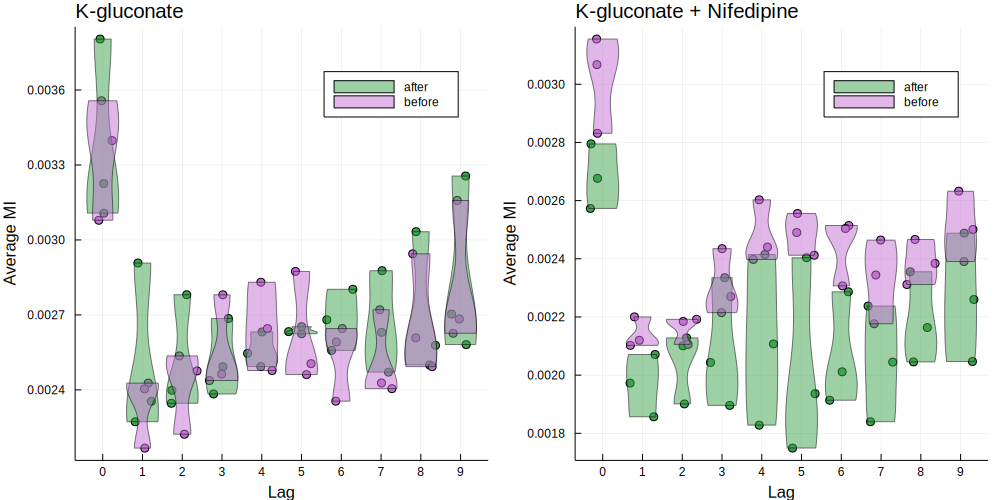

In [9]:
mi |>
    @filter(_.gh == 30 && _.gw == 30) |>
    @map({_.drug, _.trial, _.phase, _.lag, μ=mean(_.mi)}) |>
    DataFrame |>
    @infoplot :lag :μ "Lag" "Average MI"

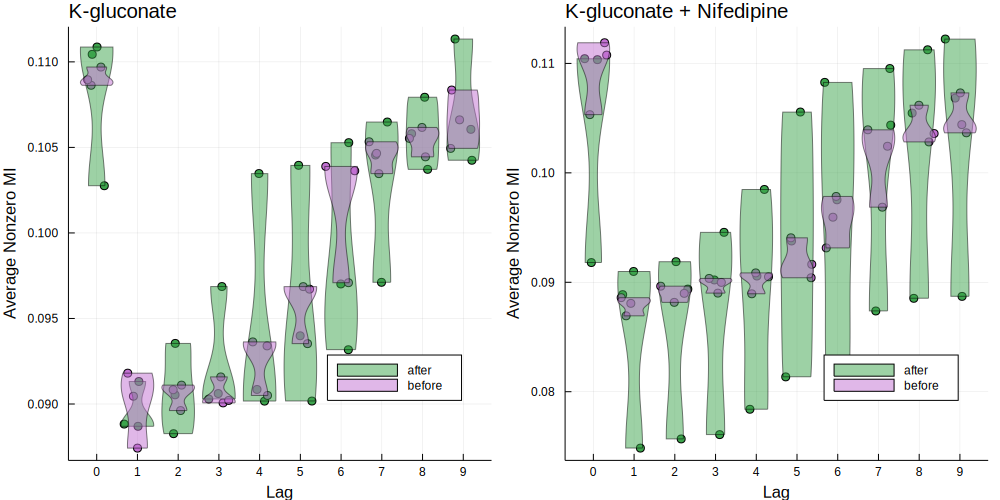

In [10]:
mi |>
    @filter(_.gh == 30 && _.gw == 30) |>
    @map({_.drug, _.trial, _.phase, _.lag, μ=mean(nonzeros(_.mi))}) |>
    DataFrame |>
    @infoplot :lag :μ "Lag" "Average Nonzero MI" :bottomright

## Transfer Entropy

In [11]:
@time te = results(:te, :k);

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info/te for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79


169.388707 seconds (726.48 k allocations: 4.256 GiB, 0.47% gc time)


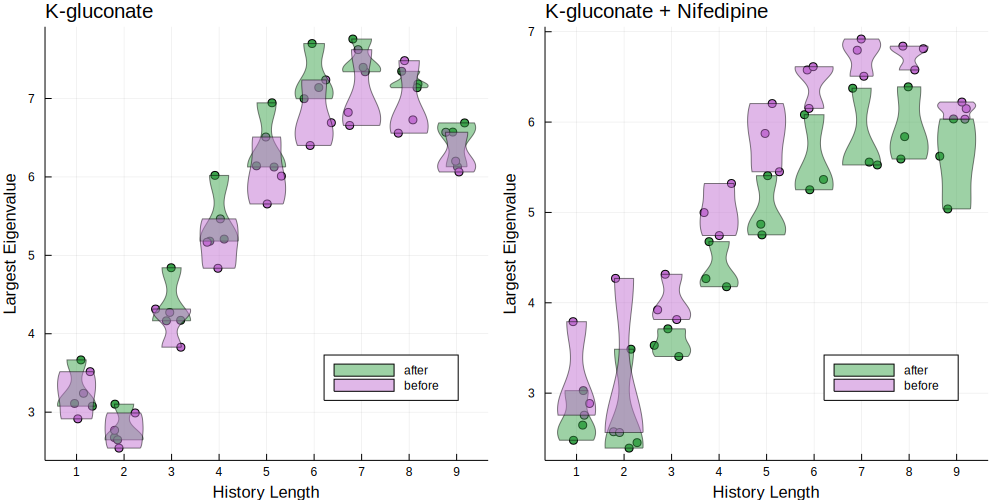

In [12]:
te |> @filter(_.gh == 30 && _.gw == 30) |> DataFrame |> @infoplot :k :eigen "History Length" "Largest Eigenvalue" :bottomright

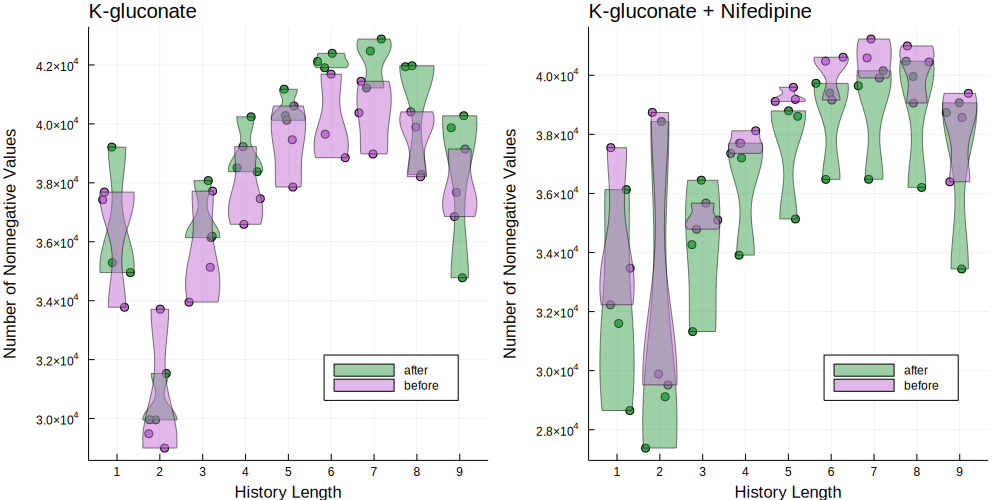

In [13]:
te |> @filter(_.gh == 30 && _.gw == 30) |> DataFrame |> @infoplot :k :nnz "History Length" "Number of Nonnegative Values" :bottomright

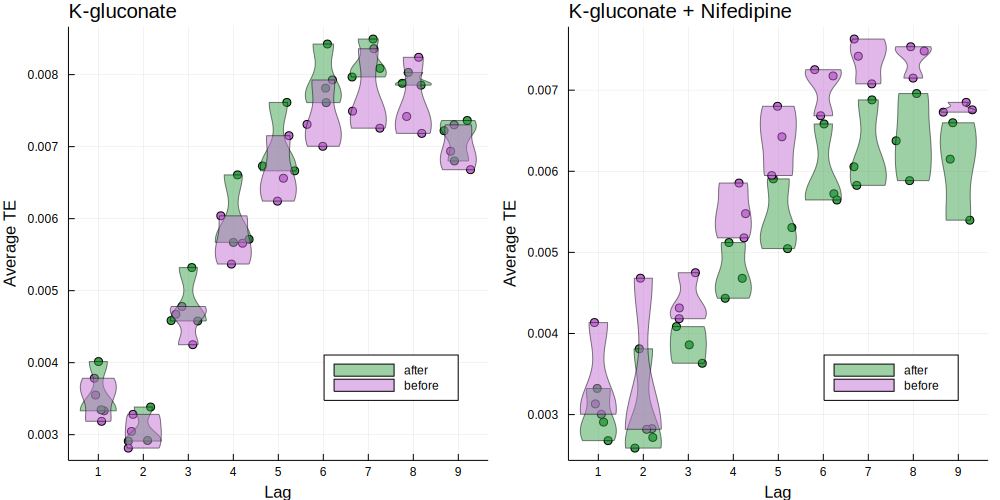

In [14]:
te |>
    @filter(_.gh == 30 && _.gw == 30) |>
    @map({_.drug, _.trial, _.phase, _.k, μ=mean(_.te)}) |>
    DataFrame |>
    @infoplot :k :μ "Lag" "Average TE" :bottomright

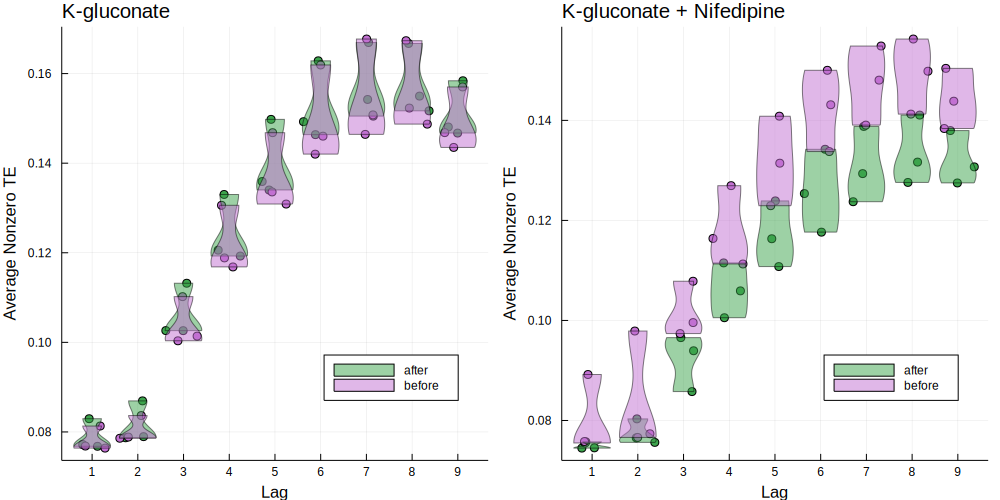

In [15]:
te |>
    @filter(_.gh == 30 && _.gw == 30) |>
    @map({_.drug, _.trial, _.phase, _.k, μ=mean(nonzeros(_.te))}) |>
    DataFrame |>
    @infoplot :k :μ "Lag" "Average Nonzero TE" :bottomright